In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]='6'

import json 
import subprocess
import requests
import re 
import sys
import torch
import torchvision
from copy import deepcopy
from PIL import Image
import requests
from io import BytesIO
import tempfile
from typing import Union, List, Tuple
import numpy as np
import os
import matplotlib.pyplot as plt
import hashlib
from torchvision import transforms
from diffusers import DPMSolverMultistepScheduler, DiffusionPipeline, DDIMScheduler
# from inverse_stable_diffusion import InversableStableDiffusionPipeline
from diffusers import DDIMInverseScheduler
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionImg2ImgPipeline
from tqdm import tqdm 

2024-08-15 23:36:33.548811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 23:36:33.568905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 23:36:33.575194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 23:36:33.591665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 23:36:34.479705: W tensorflow/compiler/tf2

In [2]:
import torch
if torch.cuda.is_available() : 
    device = "cuda"
else :
    device = "cpu"

print(f"Device : {device}")

# with open('captions_train2014_new_format.json','r') as file : 
#     data = json.load(file)


Device : cuda


In [3]:
def _circle_mask(size=64, r=10, x_offset=0, y_offset=0):
    x0 = y0 = size // 2
    x0 += x_offset
    y0 += y_offset
    y, x = torch.meshgrid(torch.arange(size), torch.arange(size))
    y = torch.flip(y, dims=[0])

    return ((x - x0)**2 + (y-y0)**2) <= r**2

def _get_pattern(shape, w_pattern='ring', generator=None):
    gt_init = torch.randn(shape, generator=generator)

    if 'rand' in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))
        gt_patch[:] = gt_patch[0]
    elif 'zeros' in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2)) * 0
    elif 'ring' in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))

        for i in range(shape[-1] // 2, 0, -1):
            tmp_mask = _circle_mask(gt_init.shape[-1], r=i)

            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch[0, j, 0, i].item()

    return gt_patch

def _transform_img(image, target_size=512):
    tform = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ]
    )
    image = tform(image)
    return 2.0 * image - 1.0


def load_keys(cache_dir):
    arrays = {}
    for file_name in os.listdir(cache_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(cache_dir, file_name)
            arrays[file_name] = np.load(file_path)
    return arrays

def probability_from_distance(dist, threshold=77, k=0.1):
    raw_prob = 1 / (1 + torch.exp(k * (dist - threshold)))
    if dist > threshold:
        return 1 - raw_prob
    return raw_prob

def detect(image, pipe):
    detection_time_num_inference = 50
    prob_threshold=0.9
    keys = load_keys(tempfile.gettempdir())

    # ddim inversion
    curr_scheduler = pipe.scheduler
    pipe.scheduler = DDIMInverseScheduler.from_config(pipe.scheduler.config)
    img = _transform_img(image).unsqueeze(0).to(pipe.unet.dtype).to(pipe.device)
    image_latents = pipe.vae.encode(img).latent_dist.mode() * 0.18215
    inverted_latents = pipe(
            prompt='',
            latents=image_latents,
            guidance_scale=1,
            num_inference_steps=detection_time_num_inference,
            output_type='latent',
        )
    inverted_latents = inverted_latents.images.float().cpu()

    # check if one key matches
    shape = image_latents.shape
    for filename, w_key in keys.items():
        w_channel, w_radius = filename.split(".npy")[0].split("_")[1:3]

        np_mask = _circle_mask(shape[-1], r=int(w_radius))
        torch_mask = torch.tensor(np_mask)
        w_mask = torch.zeros(shape, dtype=torch.bool)
        w_mask[:, int(w_channel)] = torch_mask

        # calculate the distance
        inverted_latents_fft = torch.fft.fftshift(torch.fft.fft2(inverted_latents), dim=(-1, -2))
        dist = torch.abs(inverted_latents_fft[w_mask] - w_key[w_mask]).mean().item()

        prob = probability_from_distance(torch.tensor(dist))

        # If the computed probability is above the threshold, return True
        if prob > prob_threshold:
            pipe.scheduler = curr_scheduler
            return True, prob.item()

    return False, prob.item()


In [31]:
def get_noise(pipe):
    w_channel = 3 # id for watermarked channel
    w_radius = 10 # watermark radius
    w_pattern = 'zeros' # watermark pattern
    shape = (1, 4, 64, 64)
    generator = None

    # Assuming the device is defined elsewhere in your code
    # If not, add the following line:
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # get watermark key and mask
    torch_mask = _circle_mask(shape[-1], r=w_radius).to(dtype=torch.bool, device=device)
    w_mask = torch.zeros(shape, dtype=torch.bool, device=device)
    w_mask[:, w_channel] = torch_mask

    w_key = _get_pattern(shape, w_pattern=w_pattern, generator=generator).to(device)
    width = 512
    height = 512

    # Adjusted the deprecated attribute access
    in_channels = pipe.unet.config.in_channels

    init_latents = torch.randn(
            (1, in_channels, height // 8, width // 8),
            generator=generator,
            device=device
    )

    clean_latents = deepcopy(init_latents)
    init_latents_fft = torch.fft.fftshift(torch.fft.fft2(init_latents), dim=(-1, -2))
    init_latents_fft[w_mask] = w_key[w_mask].clone()
    init_latents = torch.fft.ifft2(torch.fft.ifftshift(init_latents_fft, dim=(-1, -2))).real
    tensor_bytes = init_latents.cpu().numpy().tobytes()

    # generate a hash from the bytes
    hash_object = hashlib.sha256(tensor_bytes)
    hex_dig = hash_object.hexdigest()

    file_name = "_".join([hex_dig, str(w_channel), str(w_radius), w_pattern]) + ".npy"
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, file_name)
    np.save(file_path, w_key.cpu())

    return clean_latents, init_latents


In [32]:
import matplotlib.pyplot as plt
def visualize_tensor(tensor, name='./tmp.png'):
    channels = tensor.squeeze(0).cpu().numpy()
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    for i, ax in enumerate(axs):
        ax.imshow(channels[i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

    plt.savefig(name)
    plt.show()


In [33]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_with_bounding_box(tensor, channel=3, r=10, name='./ring_with_bbox.png'):
#     # Extract all channels
#     channels = tensor.squeeze(0).cpu().numpy()

#     fig, axs = plt.subplots(1, channels.shape[0], figsize=(12, 3))

#     for i, ax in enumerate(axs):
#         ax.imshow(channels[i], cmap='gray')
#         ax.set_title(f'Channel {i+1}')
#         ax.axis('off')

#         # Add bounding box only to the specified channel
#         if i == channel:
#             size = channels[i].shape[0]
#             center = size // 2
#             mask = _circle_mask(size=size, r=r)

#             # Get the bounding box of the ring
#             y, x = np.where(mask)
#             x_min, x_max = x.min(), x.max()
#             y_min, y_max = y.min(), y.max()

#             # Add a bounding box
#             bbox = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
#                                  edgecolor='red', facecolor='none', linewidth=2)
#             ax.add_patch(bbox)

#     # Save and show the image
#     plt.savefig(name)
#     plt.show()

def plot_with_bounding_box(tensor, channel=3, r=10, expansion=3, name='./ring_with_bbox.png'):
    # Extract all channels
    channels = tensor.squeeze(0).cpu().numpy()

    fig, axs = plt.subplots(1, channels.shape[0], figsize=(12, 3))

    for i, ax in enumerate(axs):
        ax.imshow(channels[i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

        # Add bounding box only to the specified channel
        if i == channel:
            size = channels[i].shape[0]
            center = size // 2
            mask = _circle_mask(size=size, r=r)

            # Get the bounding box of the ring
            y, x = np.where(mask)
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()

            # Expand the bounding box by a specified amount
            x_min = max(x_min - expansion, 0)
            x_max = min(x_max + expansion, size - 1)
            y_min = max(y_min - expansion, 0)
            y_max = min(y_max + expansion, size - 1)

            # Add a bounding box
            bbox = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(bbox)

    # Save and show the image
    plt.savefig(name)
    plt.show()




In [34]:
model_id = 'stabilityai/stable-diffusion-2-1-base'


In [24]:
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder='scheduler')
pipeline1 = DiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
# pipeline2 = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline1 = pipeline1.to(device)
# pipeline2 = pipeline2.to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [35]:
clean_latents, wm_latents = get_noise(pipeline1)


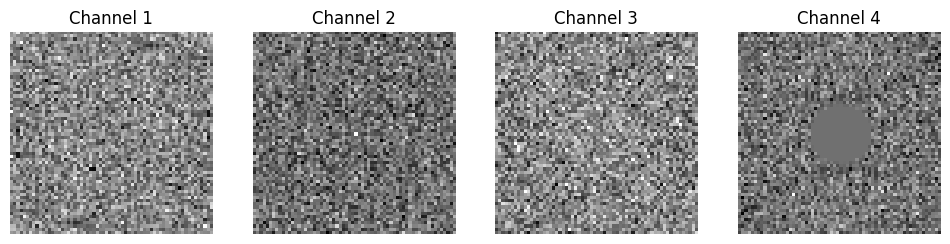

In [36]:
init_latents_w_fft_real = torch.fft.fftshift(torch.fft.fft2(wm_latents), dim=(-1, -2)).real
visualize_tensor(init_latents_w_fft_real, name='./real.png')


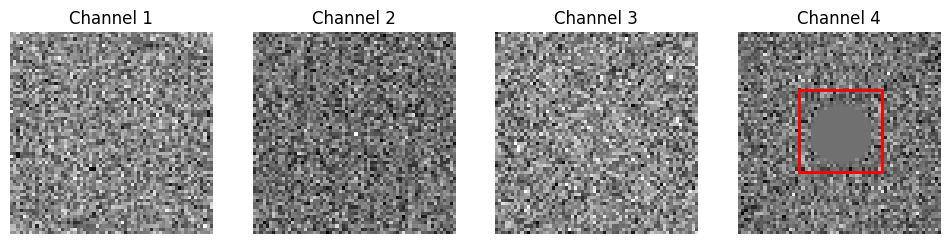

In [40]:
# Assuming init_latents_w_fft is already defined as the FFT of the watermark latents
plot_with_bounding_box(init_latents_w_fft_real, channel=3, r=10, name='./zeros_real_with_bbox.png')


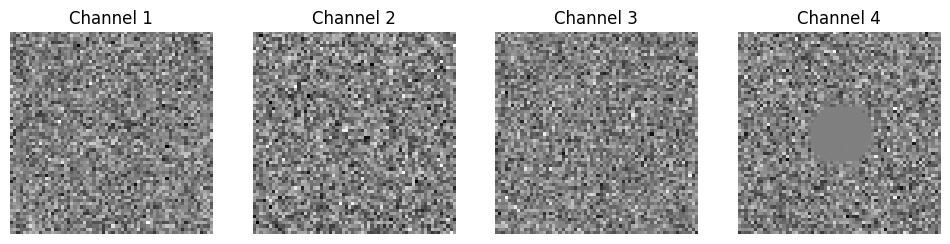

In [41]:
init_latents_w_fft_img = torch.fft.fftshift(torch.fft.fft2(wm_latents), dim=(-1, -2)).imag
visualize_tensor(init_latents_w_fft_img, name='./imag.png')


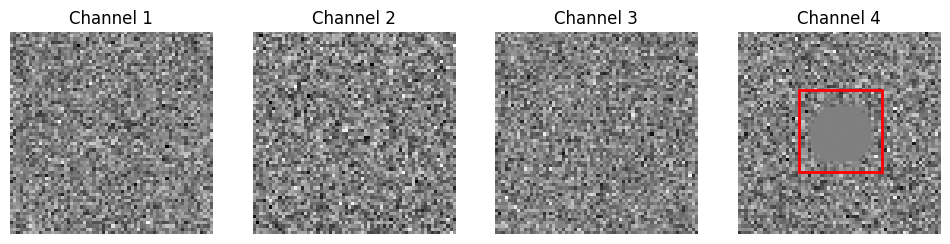

In [42]:
plot_with_bounding_box(init_latents_w_fft_img, channel=3, r=10, name='./zeros_imag_with_bbox.png')


In [ ]:
for i in tqdm(range(len(img_ids))) : 
    scheduler = DDIMScheduler.from_pretrained(model_id, subfolder='scheduler')
    pipeline1 = DiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
    # pipeline2 = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipeline1 = pipeline1.to(device)
    # pipeline2 = pipeline2.to(device)

    print(f'Image Id : {img_ids[i]}')

    clean_latents, wm_latents = get_noise(pipeline1)
    neg_prompt = 'deformity, bad anatomy, cloned face, amputee, people in background, asymmetric, disfigured, extra limbs, text, missing legs, missing arms, Out of frame, low quality, Poorly drawn feet'
    # print(f"Prompt[i] : {prompt[i]}")

    det_prob = 0 

    for j in range(len(captions[i])) :
        with torch.autocast("cuda"):
            watermarked_image = pipeline1(
                captions[i][j],
                latents = wm_latents,
                num_inference_steps=250,
                negative_prompt = neg_prompt,
            ).images[0]

        print(f"Initial watermarked image generated for {img_ids[i]}")
        print(watermarked_image.size)
        print(watermarked_image)

        is_watermarked, probability = detect(watermarked_image, pipeline1)
        det_prob = det_prob + probability 

        print(f'is_watermarked: {is_watermarked}, probability : {probability}')
        print()

            # Ensure the image is in PIL format
        if not isinstance(watermarked_image, Image.Image):
            watermarked_image = Image.fromarray(watermarked_image)

        # print()

        # Define the directory and filename
        directory = f'{watermark_path}/{img_ids[i]}'
        

        # Create the directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Save the image to the specified directory with the specified filename
        # for copy_count in range(4) :
        # for j in range(5) : 
        filename = f'{img_ids[i]}_watermarked_caption_{j}.png'
        watermarked_image.save(os.path.join(directory, filename))
        print(f"Image saved to {os.path.join(directory, filename)}")

    original_avg_detection_prob[img_ids[i]] = det_prob/5
